In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

# Heirarchical Clustering Step by Step

----

The focus here isn't on the code but the concepts behind the clustering method.

If viewing this in Jupyter, toggle off the code cells so they're hidden.  To do this toggling, you can click in the margin of the notebook and then press the <kbd>T</kbd> key on your keyboard.

----

In [2]:
from IPython.display import display_html

import numpy as np
import pandas as pd

from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram
from scipy.spatial.distance import pdist, squareform

import seaborn as sns
import matplotlib.pyplot as plt

from heir_demo_utils import label_scatter, dist_mat_to_tall, merge_closest_pair

%matplotlib inline

<IPython.core.display.Javascript object>

In [3]:
def display_side_by_side(*dfs):
    html_str = ""
    for df in dfs:
        html_str += df.to_html()
    display_html(html_str.replace("table", 'table style="display:inline"'), raw=True)

<IPython.core.display.Javascript object>

Our data:

In [4]:
np.random.seed(1234)

data = np.random.normal(5, 2, size=14).reshape(7, 2)
df = pd.DataFrame(data, index=["A", "B", "C", "D", "E", "F", "G"], columns=["x", "y"])
df

,x,y
A,5.942870,2.618049
B,7.865414,4.374696
C,3.558823,6.774326
D,6.719177,3.726953
E,5.031393,0.514630
F,7.300071,6.983892
G,6.906648,0.957490


<IPython.core.display.Javascript object>

Our data visualized:

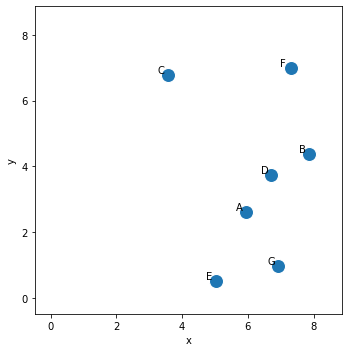

<IPython.core.display.Javascript object>

In [5]:
mn = df.min().min() - 1
mx = df.max().max() + 1

plt.figure(figsize=(5, 5))

sns.scatterplot(x="x", y="y", data=df, s=200)
label_scatter("x", "y", df.index, data=df)

plt.axis("square")
plt.xlim(mn, mx)
plt.ylim(mn, mx)

plt.tight_layout()
plt.show()

## Clustering Step 0:

* Measure the distance between each pair of observations

Here, euclidean distance was used.

In [6]:
dist_mat = squareform(pdist(df))
dist_mat = pd.DataFrame(dist_mat, columns=df.index, index=df.index)

# Make a tall version of the distance matrix for later
dist_df = dist_mat_to_tall(dist_mat)

dist_mat.style.background_gradient(axis=None)

,A,B,C,D,E,F,G
A,0.000000,2.604224,4.791485,1.353632,2.292414,4.571934,1.919980
B,2.604224,0.000000,4.930005,1.316598,4.788714,2.669741,3.549159
C,4.791485,4.930005,0.000000,4.390253,6.430572,3.747114,6.711446
D,1.353632,1.316598,4.390253,0.000000,3.628723,3.308337,2.775801
E,2.292414,4.788714,6.430572,3.628723,0.000000,6.855527,1.926839
F,4.571934,2.669741,3.747114,3.308337,6.855527,0.000000,6.039230
G,1.919980,3.549159,6.711446,2.775801,1.926839,6.039230,0.000000


<IPython.core.display.Javascript object>

## Clustering Step 1:

* Find the closest 2 observations in the distance matrix:

In [7]:
two_closest = dist_df.sort_values("dist").head(1)
two_closest

,sample_1,sample_2,dist
4,B,D,1.316598


<IPython.core.display.Javascript object>

## Clustering Step 2:

* In the distance matrix, combine the rows/columns of the 2 closest samples so that they become 1 combined observation (see matrix below)

...but how do we handle the distances for the combined observation?

In [8]:
merge = sorted([two_closest.iloc[0, 0], two_closest.iloc[0, 1]])
merged_name = f"({merge[0]}, {merge[1]})"

# Make a new distance matrix
merged_dist_mat = dist_mat.drop(index=[merge[1]], columns=[merge[1]])
merged_dist_mat = merged_dist_mat.rename(
    index={merge[0]: merged_name}, columns={merge[0]: merged_name}
)
merged_dist_mat.loc[:, merged_name] = np.nan
merged_dist_mat.loc[merged_name, :] = np.nan
merged_dist_mat.loc[merged_name, merged_name] = 0
merged_dist_mat.style.background_gradient(axis=None)

,A,"(B, D)",C,E,F,G
A,0.000000,nan,4.791485,2.292414,4.571934,1.919980
"(B, D)",nan,0.000000,nan,nan,nan,nan
C,4.791485,nan,0.000000,6.430572,3.747114,6.711446
E,2.292414,nan,6.430572,0.000000,6.855527,1.926839
F,4.571934,nan,3.747114,6.855527,0.000000,6.039230
G,1.919980,nan,6.711446,1.926839,6.039230,0.000000


<IPython.core.display.Javascript object>

Below are all the relationships that we need to address.  How do we combine the duplicated pairs of rows into a single record?

In [9]:
# Filter to rows that concern the merging pair
# Remove row for the pair
merge_dist_df = dist_df[
    dist_df["sample_1"].isin(merge) | dist_df["sample_2"].isin(merge)
]
merge_dist_df = merge_dist_df[
    ~(merge_dist_df["sample_1"].isin(merge) & merge_dist_df["sample_2"].isin(merge))
]

# Swap values so sample_2 is always the merge pair
swap_rows = merge_dist_df["sample_1"].isin(merge)
copy = merge_dist_df.copy()
merge_dist_df.loc[swap_rows, "sample_1"] = copy.loc[swap_rows, "sample_2"]
merge_dist_df.loc[swap_rows, "sample_2"] = copy.loc[swap_rows, "sample_1"]
merge_dist_df.loc[:, "sample_2"] = merged_name

merge_dist_df = merge_dist_df.sort_values("sample_1")
merge_dist_df

,sample_1,sample_2,dist
0,A,"(B, D)",2.604224
3,A,"(B, D)",1.353632
2,C,"(B, D)",4.930005
5,C,"(B, D)",4.390253
7,E,"(B, D)",4.788714
9,E,"(B, D)",3.628723
11,F,"(B, D)",2.669741
13,F,"(B, D)",3.308337
16,G,"(B, D)",3.549159
18,G,"(B, D)",2.775801


<IPython.core.display.Javascript object>

We could:
* Combine by taking the **minimum** dist from each collapsing pair.
    * This is also referred to as 'single linkage'.
    * This has the effect of making the merged pair closer to every other observation.
    
    
* Combine by taking the **maximum** dist from each collapsing pair.
    * This is also referred to as 'complete linkage'.
    * This has the effect of making the merged pair further from every other observation.
    
    
* Combine by taking the **mean** dist from each collapsing pair.
    * This is also referred to as 'average linkage'.

In [10]:
merged_dists_min = merge_dist_df.groupby("sample_1").agg({"dist": "min"})
merged_dists_max = merge_dist_df.groupby("sample_1").agg({"dist": "max"})
merged_dists = merge_dist_df.groupby("sample_1").agg({"dist": "mean"})

merged_dists_min.columns = ["single_linkage"]
merged_dists_max.columns = ["compete_linkage"]
merged_dists.columns = ["avg_linkage"]

pd.concat((merged_dists_min, merged_dists_max, merged_dists), axis=1)

,single_linkage,compete_linkage,avg_linkage
sample_1,,,
A,1.353632,2.604224,1.978928
C,4.390253,4.930005,4.660129
E,3.628723,4.788714,4.208719
F,2.669741,3.308337,2.989039
G,2.775801,3.549159,3.162480


<IPython.core.display.Javascript object>

Let's take the middle ground for now and use average linkage.

In [11]:
for name, row in merged_dists.iterrows():
    merged_dist_mat.loc[name, merged_name] = row["avg_linkage"]
    merged_dist_mat.loc[merged_name, name] = row["avg_linkage"]

merged_dist_mat.style.background_gradient(axis=None)

,A,"(B, D)",C,E,F,G
A,0.000000,1.978928,4.791485,2.292414,4.571934,1.919980
"(B, D)",1.978928,0.000000,4.660129,4.208719,2.989039,3.162480
C,4.791485,4.660129,0.000000,6.430572,3.747114,6.711446
E,2.292414,4.208719,6.430572,0.000000,6.855527,1.926839
F,4.571934,2.989039,3.747114,6.855527,0.000000,6.039230
G,1.919980,3.162480,6.711446,1.926839,6.039230,0.000000


<IPython.core.display.Javascript object>

## Clustering Step 3:

And repeat!

Note, if we know we want to end up with `k` clusters.  We can stop this process as soon as we get to `k` clusters.

In [12]:
ordinal_nums = ["Second", "Third", "Fourth", "Fifth", "Sixth (Final)"]
for num in ordinal_nums:
    print(f"\n{num} merge:")
    merged_dist_mat = merge_closest_pair(merged_dist_mat)
    display(merged_dist_mat.style.background_gradient(axis=None))


Second merge:


,"(A, G)","(B, D)",C,E,F
"(A, G)",0.000000,2.570704,5.751465,2.109626,5.305582
"(B, D)",2.570704,0.000000,4.660129,4.208719,2.989039
C,5.751465,4.660129,0.000000,6.430572,3.747114
E,2.109626,4.208719,6.430572,0.000000,6.855527
F,5.305582,2.989039,3.747114,6.855527,0.000000



Third merge:


,"(B, D)",C,"(E, (A, G))",F
"(B, D)",0.000000,4.660129,3.389711,2.989039
C,4.660129,0.000000,6.091019,3.747114
"(E, (A, G))",3.389711,6.091019,0.000000,6.080555
F,2.989039,3.747114,6.080555,0.000000



Fourth merge:


,C,"(E, (A, G))","(F, (B, D))"
C,0.000000,6.091019,4.203621
"(E, (A, G))",6.091019,0.000000,4.735133
"(F, (B, D))",4.203621,4.735133,0.000000



Fifth merge:


,"(C, (F, (B, D)))","(E, (A, G))"
"(C, (F, (B, D)))",0.000000,5.413076
"(E, (A, G))",5.413076,0.000000



Sixth (Final) merge:


,"((C, (F, (B, D))), (E, (A, G)))"
"((C, (F, (B, D))), (E, (A, G)))",0.000000


<IPython.core.display.Javascript object>

## Visualizing results

One way to visualize this process is with the below plot (called a 'dendrogram').  Depending on where we 'cut' this, we can get a different number of clusters.

For example, we might cut in a way to end up with clusters:
* `(E, (A, G))`
* `(F, (B, D))`
* `C`

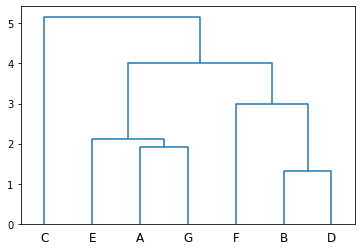

<IPython.core.display.Javascript object>

In [13]:
avg_linkage = hierarchy.linkage(df, method="average")
hierarchy.dendrogram(avg_linkage, labels=df.index, color_threshold=0)
plt.show()

Here's a visualization of this in context of our 2d scatter plot:

<img src='images/average_linkage.gif' width='50%'>

##  Step 2 revisited with single linkage

We get a different build up of parts.  In average linkage, we first merged `(B, D)` and then `(A, G)` - despite `A` and `D` being so close.  The average distance of `B->A` and `D->A` pushed `A->F` to be closer than `(B, D)->A`.  However, using the minimum distance we end up with `(B, D)->A` being closer together.

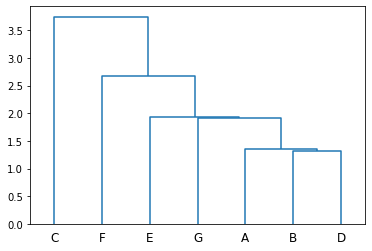

<IPython.core.display.Javascript object>

In [14]:
single_linkage = hierarchy.linkage(df, method="single")
hierarchy.dendrogram(single_linkage, labels=df.index, color_threshold=0)
plt.show()

Here's a visualization of this in context of our 2d scatter plot:

<img src='images/single_linkage.gif' width='50%'>

##  Step 2 revisited with complete linkage

We get a different build up of parts again, on your own, compare and contrast what happened with complete linkage to the other methods.

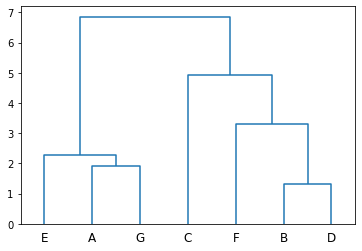

<IPython.core.display.Javascript object>

In [15]:
complete_linkage = hierarchy.linkage(df, method="complete")
hierarchy.dendrogram(complete_linkage, labels=df.index, color_threshold=0)
plt.show()

Here's a visualization of this in context of our 2d scatter plot:

<img src='images/complete_linkage.gif' width='50%'>

## Linkage Comparison

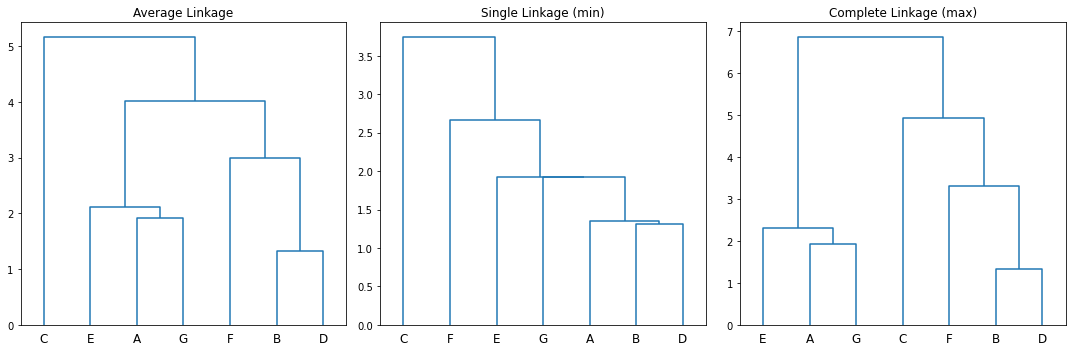

<IPython.core.display.Javascript object>

In [16]:
cut_point = 0

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

hierarchy.dendrogram(
    avg_linkage, labels=df.index, color_threshold=cut_point, ax=axes[0]
)
hierarchy.dendrogram(
    single_linkage, labels=df.index, color_threshold=cut_point, ax=axes[1]
)
hierarchy.dendrogram(
    complete_linkage, labels=df.index, color_threshold=cut_point, ax=axes[2]
)
axes[0].set_title("Average Linkage")
axes[1].set_title("Single Linkage (min)")
axes[2].set_title("Complete Linkage (max)")
plt.tight_layout()
plt.show()

These linkages can change how things are grouped.  Here's what would happen in each case if we 'cut' our dendrogram tree at the value 3.

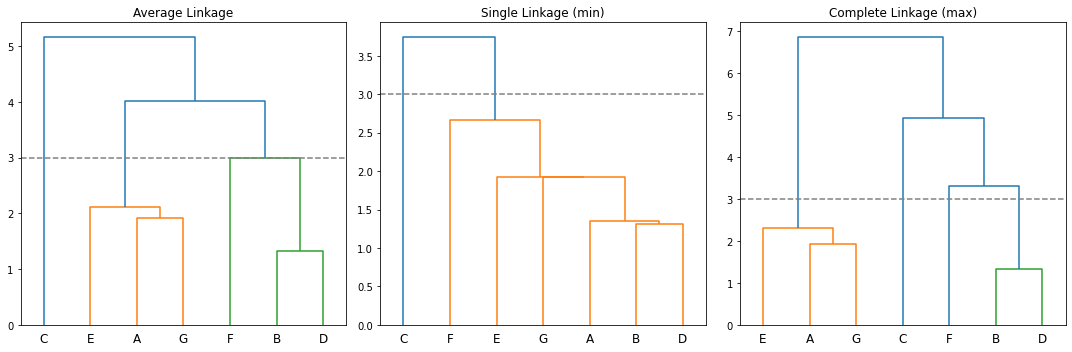

<IPython.core.display.Javascript object>

In [17]:
cut_point = 3

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

hierarchy.dendrogram(
    avg_linkage, labels=df.index, color_threshold=cut_point, ax=axes[0]
)
hierarchy.dendrogram(
    single_linkage, labels=df.index, color_threshold=cut_point, ax=axes[1]
)
hierarchy.dendrogram(
    complete_linkage, labels=df.index, color_threshold=cut_point, ax=axes[2]
)
axes[0].axhline(cut_point, ls="--", c="gray")
axes[1].axhline(cut_point, ls="--", c="gray")
axes[2].axhline(cut_point, ls="--", c="gray")

axes[0].set_title("Average Linkage")
axes[1].set_title("Single Linkage (min)")
axes[2].set_title("Complete Linkage (max)")
plt.tight_layout()
plt.show()

## Ward Linkage

There's a final common linkage to use in this clustering method.  This method collapses the distances in our distance matrix using the original locations of the data.  This method, just like k-Means, is only applicable if euclidean distance is a good distance metric for your data.  It also uses a notion of an average centroid being a good middle point of a cluster.

For example, if we merge `B` and `D`, then we place an imaginary point in the middle of these 2 observations.  Instead of using min/max/avg, we'll measure the new distance from every other point to this new cluster center point.

If we continue after merging `(B, D)`, maybe the next step is to merge `(B, D)` and `A`.  We now find the middle point of `B`, `D`, and `A` as our new cluster center and remeasure distances.